In [21]:
# -*- coding: utf-8 -*-

import scipy.io
import numpy as np
import tensorflow as tf
import sklearn as sk
import matplotlib.pyplot as plt
import itertools
import random

from numba import cuda
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import  EarlyStopping

In [22]:
# tensorflow = 2.
# python = 3.6


seed = np.random.seed(777)

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    
  try:
      
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
      
  except RuntimeError as e:
      
    print(e)


val_loss_all = []

test_loss_all = []
test_acc_all = []
test_pre_all = []
frr_all = []
far_all = []

conf_matrix_sco = []
test_pre_sco = []
test_rec_sco = []
test_spedi_sco = []
test_sensi_sco = []

class MyModelCheckpoint(tf.keras.callbacks.ModelCheckpoint):

    def __init__(self, *args, **kwargs):
        super(MyModelCheckpoint, self).__init__(*args, **kwargs)

    # redefine the save so it only activates after 100 epochs
    def on_epoch_end(self, epoch, logs=None):
        if epoch >= 1: super(MyModelCheckpoint, self).on_epoch_end(epoch, logs)

In [23]:
train_data = scipy.io.loadmat('../../datas/160hz/train_5day_160hz.mat', squeeze_me=True)['data']
test_data = scipy.io.loadmat('../../datas/160hz/test_6day_160hz(2).mat', squeeze_me=True)['data']

# sub 수
sub_cnt = train_data.shape[0]

# 3sec 데이터 크기
data_size = 480

# 1명당 3초 데이터 개수
train_data_cnt = 1052
test_data_cnt = 211

# 3sec 480(= 160*3) 크기로 데이터 길이 설정
train_cut_size = 504960 # 480*1052 = 504960
test_cut_size = 101280 # 480*211 = 101280

# 3sec 데이터 길이 자르기
# train: 504,960 / test: 101,280
train_data = train_data[:,0:train_cut_size,:]
test_data = test_data[:,0:test_cut_size,:]

# flatten(): 3D -> 1D / reshape(-1,1): -1 마지막 인덱스
train_flatten = train_data.flatten().reshape(-1,1)
test_flatten = test_data.flatten().reshape(-1,1)

# StandardScaler(): train에 맞춰 표준화
data_scaler = StandardScaler()
    
data_scaler.fit(train_flatten)
train_scaler = data_scaler.transform(train_flatten)
test_scaler = data_scaler.transform(test_flatten)
    
# train, test 데이터 reshape
train_data = train_scaler.reshape(train_data_cnt * sub_cnt, data_size, 2) 
test_data = test_scaler.reshape(test_data_cnt * sub_cnt, data_size, 2)

#train data를 sub:other=1:1로 만들기 위해서 각 sub 추출
train_data_each = []
for i in range(sub_cnt):
    train_data_each.insert(i, train_data[i*train_data_cnt:(i+1)*train_data_cnt, :, :])
print(np.shape(train_data_each))

#test data를 sub:other=1:3로 만들기 위해서 각 sub 추출
test_data_each = []
for i in range(sub_cnt):
    test_data_each.insert(i, test_data[i*test_data_cnt:(i+1)*test_data_cnt, :, :])
print(np.shape(test_data_each))

(11, 1052, 480, 2)
(11, 211, 480, 2)


In [24]:
# sub number
sub_num = 10

#1 to 3 비율로 설정
ratio = 3

train_data_n = train_data_each[sub_num]
test_data_n = test_data_each[sub_num]

# train data를 sub:other = 1:3으로 만들기
# 3초 덩어리 개수 1052 : 3156
# => 315 * 4 + 316 * 6 = 1260 + 1896 = 3156

# test data를 sub:other = 1:3로 만들기
# 3초 덩어리 개수 211 : 633
# 63 * 7 + 64 * 3 = 633

cnt = 0
for j in range(sub_cnt):
    if j != sub_num and cnt < 4:
        cnt = cnt + 1
        train_data_n = np.append(train_data_n, np.array(random.sample(list(train_data_each[j]), 315)), axis = 0)
    elif j != sub_num and cnt >= 4:
        train_data_n = np.append(train_data_n, np.array(random.sample(list(train_data_each[j]), 316)), axis = 0)
#     print("train_data_n.shape")
#     print(train_data_n.shape)
#     print("train_data_n")
#     print(train_data_n)
        
cnt = 0
for j in range(sub_cnt):
    if j != sub_num and cnt < 7:
        cnt = cnt + 1
        test_data_n = np.append(test_data_n, np.array(random.sample(list(test_data_each[j]), 63)), axis = 0)
    elif j != sub_num and cnt >= 7:
        test_data_n = np.append(test_data_n, np.array(random.sample(list(test_data_each[j]), 64)), axis = 0)
        
        
        
train_label = np.zeros(train_data_cnt*(ratio+1))
test_label = np.zeros(test_data_cnt*(ratio+1))

for j in range(len(train_label)):
    if (j < train_data_cnt):
        train_label[j] = 1

for j in range(len(test_label)):
    if (j < test_data_cnt):
        test_label[j] = 1
        
train_data_shuffled, train_label_shuffled = sk.utils.shuffle(train_data_n, train_label, random_state = 0)

val_data_set = train_data_shuffled[:train_data_cnt]
train_data_set = train_data_shuffled[train_data_cnt:]

val_label_set = train_label_shuffled[:train_data_cnt]
train_label_set = train_label_shuffled[train_data_cnt:]
  

Epoch 1/200
99/99 [==============================] - 2s 24ms/step - loss: 0.5482 - accuracy: 0.7452 - val_loss: 0.5611 - val_accuracy: 0.7367
Epoch 2/200
97/99 [============================>.] - ETA: 0s - loss: 0.4758 - accuracy: 0.7545
Epoch 00002: val_loss improved from inf to 0.45723, saving model to best_model_11.h5
99/99 [==============================] - 2s 21ms/step - loss: 0.4749 - accuracy: 0.7544 - val_loss: 0.4572 - val_accuracy: 0.7376
Epoch 3/200
97/99 [============================>.] - ETA: 0s - loss: 0.4556 - accuracy: 0.7613
Epoch 00003: val_loss improved from 0.45723 to 0.44605, saving model to best_model_11.h5
99/99 [==============================] - 2s 21ms/step - loss: 0.4557 - accuracy: 0.7614 - val_loss: 0.4460 - val_accuracy: 0.8108
Epoch 4/200
97/99 [============================>.] - ETA: 0s - loss: 0.4425 - accuracy: 0.8006
Epoch 00004: val_loss improved from 0.44605 to 0.43190, saving model to best_model_11.h5
99/99 [==============================] - 2s 21ms/s

Epoch 30/200
97/99 [============================>.] - ETA: 0s - loss: 0.2788 - accuracy: 0.8892
Epoch 00030: val_loss did not improve from 0.29004
99/99 [==============================] - 2s 21ms/step - loss: 0.2780 - accuracy: 0.8901 - val_loss: 0.3077 - val_accuracy: 0.8850
Epoch 31/200
97/99 [============================>.] - ETA: 0s - loss: 0.2901 - accuracy: 0.8882
Epoch 00031: val_loss did not improve from 0.29004
99/99 [==============================] - 2s 21ms/step - loss: 0.2893 - accuracy: 0.8881 - val_loss: 0.3391 - val_accuracy: 0.8774
Epoch 32/200
97/99 [============================>.] - ETA: 0s - loss: 0.2787 - accuracy: 0.8831
Epoch 00032: val_loss did not improve from 0.29004
99/99 [==============================] - 2s 21ms/step - loss: 0.2783 - accuracy: 0.8824 - val_loss: 0.3805 - val_accuracy: 0.8384
Epoch 33/200
97/99 [============================>.] - ETA: 0s - loss: 0.2870 - accuracy: 0.8779
Epoch 00033: val_loss did not improve from 0.29004
99/99 [===============

97/99 [============================>.] - ETA: 0s - loss: 0.2532 - accuracy: 0.9021
Epoch 00059: val_loss did not improve from 0.26875
99/99 [==============================] - 2s 21ms/step - loss: 0.2527 - accuracy: 0.9030 - val_loss: 0.2824 - val_accuracy: 0.8821
Epoch 60/200
97/99 [============================>.] - ETA: 0s - loss: 0.2675 - accuracy: 0.8921
Epoch 00060: val_loss did not improve from 0.26875
99/99 [==============================] - 2s 21ms/step - loss: 0.2684 - accuracy: 0.8920 - val_loss: 0.3468 - val_accuracy: 0.8755
Epoch 61/200
97/99 [============================>.] - ETA: 0s - loss: 0.2770 - accuracy: 0.8843
Epoch 00061: val_loss did not improve from 0.26875
99/99 [==============================] - 2s 21ms/step - loss: 0.2758 - accuracy: 0.8853 - val_loss: 0.2891 - val_accuracy: 0.8840
Epoch 62/200
97/99 [============================>.] - ETA: 0s - loss: 0.2608 - accuracy: 0.8927
Epoch 00062: val_loss did not improve from 0.26875
99/99 [============================

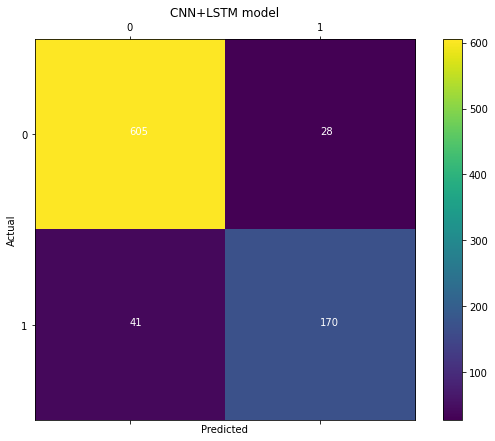

val_loss: 0.2687532603740692
test_loss: 0.21645528078079224
test_acc: 0.9182464480400085
precision: 0.8585858585858586
recall: 0.8056872037914692
specificity 0.9557661927330173
sensitivity :  0.8056872037914692
far 0.044233807266982623
frr 0.1943127962085308


In [25]:
# model CNN-LSTM    
inputs = tf.keras.Input(shape = (480, 2))
conv_1 = tf.keras.layers.Conv1D(filters = 76, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(inputs)
max_1 = tf.keras.layers.MaxPool1D(3)(conv_1)
    
conv_2 = tf.keras.layers.Conv1D(filters = 20, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(max_1)
max_2 = tf.keras.layers.MaxPool1D(3)(conv_2)
    
conv_3 = tf.keras.layers.Conv1D(filters = 9, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(max_2)
max_3 = tf.keras.layers.MaxPool1D(3)(conv_3)
    

D_out_1 = tf.keras.layers.Dropout(0.569149552203474)(max_3)
    
    
lstm_1 = tf.keras.layers.LSTM(232)(D_out_1)
    
dense_1 = tf.keras.layers.Dense(32, activation = 'relu')(lstm_1)
dense_2 = tf.keras.layers.Dense(21, activation = 'relu')(dense_1)
# dense_3 = tf.keras.layers.Dense(134, activation = 'relu')(dense_2)
dense_4 = tf.keras.layers.Dense(1, activation = 'sigmoid')(dense_2)
    
model = tf.keras.models.Model(inputs = inputs, outputs = dense_4)

# Adam
model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(0.009755746313544013), metrics = ['accuracy'])
# SGD
# model.compile(loss= 'binary_crossentropy', optimizer= tf.keras.optimizers.SGD(learning_rate=0.08119450015184537, momentum=0.4770521140454941), metrics=['accuracy'])
    
# EarlyStopping 조기종료 및 모델 학습
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 20)
check_point = MyModelCheckpoint('best_model_' + str(sub_num + 1) + '.h5', monitor = 'val_loss', mode = 'min', save_best_only = True, verbose = 1)

# EarlyStopping 사용
hist = model.fit(train_data_set, train_label_set, epochs = 200, batch_size = 32, validation_data = (val_data_set, val_label_set), callbacks = [early_stopping, check_point])
# EarlyStopping 미사용
# hist = model.fit(train_data_set, train_label_set, epochs = 200, batch_size = 32, validation_data = (val_data_set, val_label_set), callbacks = [check_point])
        
# model save .h5형식
model = tf.keras.models.load_model('best_model_' + str(sub_num + 1) + '.h5')
model.save('Binary_BOHB_' + str(sub_num + 1) + '.h5')
model.summary() 
        
val_loss, val_acc = model.evaluate(val_data_set, val_label_set, verbose = 2)

test_loss, test_acc = model.evaluate(test_data_n, test_label, verbose = 2)
test_pred = model.predict(test_data_n)
        
    
# 각 행은 1sec, 0.5 <= 자신, 0.5 > 타인
for i in range(len(test_pred)):
    if(test_pred[i] >= 0.5):
        test_pred[i] = 1
    
    else: 
        test_pred[i] = 0
    
    
val_loss_all.append(val_loss)
    
test_loss_all.append(test_loss)
test_acc_all.append(test_acc)
test_pre_all.append(test_pred)
    

conf_matrix = confusion_matrix(test_label, test_pred) 
conf_matrix_sco.append(conf_matrix)
    
conf_row = conf_matrix.sum(axis = 1)
conf_col = conf_matrix.sum(axis = 0)

precision = conf_matrix[1][1] / conf_col[1]
recall = conf_matrix[1][1] / conf_row[1]
specificity = conf_matrix[0][0] / conf_row[0]
sensitivity = conf_matrix[1][1] / conf_row[1]
frr = conf_matrix[1][0] / (conf_matrix[1][1]+conf_matrix[1][0])
far = conf_matrix[0][1] / (conf_matrix[0][1]+conf_matrix[0][0])
    
frr_all.append(frr)
far_all.append(far)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

cax = ax.matshow(conf_matrix)

fig.colorbar(cax)

for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, conf_matrix[i, j], color="white")

plt.title('CNN+LSTM model')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()
 
    
test_pre_sco.append(precision)
test_rec_sco.append(recall)
test_spedi_sco.append(specificity)
test_sensi_sco.append(sensitivity)
    
print('val_loss:', val_loss)
print('test_loss:', test_loss)
print('test_acc:', test_acc)
    
print('precision:', precision)
print('recall:', recall)
print('specificity', specificity)
print('sensitivity : ', sensitivity)
print('far', far)
print('frr', frr)